In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
import re
import requests

import nltk
nltk.download('stopwords')

Matplotlib is building the font cache; this may take a moment.
[nltk_data] Downloading package stopwords to C:\Users\Полина
[nltk_data]     Сергеевна\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [2]:
SEED = 42

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
ttrain_df = train_df[0:3000000] #### >2/3
ttest_df = test_df[0:3000000]

# Exploratory Data Analysis and Metric

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [6]:
train_df.shape, test_df.shape

((3159633, 2), (2784634, 2))

In [7]:
train_df.head(15)

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
5,"Na primjer , pjesnik ga opisuje ovako .",hr
6,Semua rerumputan itu sekarang menutupi tanah s...,id
7,Det är en enorm utmaning för oss att göra det .,sv
8,Ono što ćete vidjeti - trebat ćete skočiti ovd...,hr
9,( Alqışlar ) Excel-dən istifadə etmişəm .,az


In [8]:
lang_count = (
    train_df.language.value_counts()
    .to_frame()
    .reset_index()
)

lang_count.head()

,index,language
0,ru,181970
1,en,157655
2,fr,148585
3,vi,113193
4,ar,110032


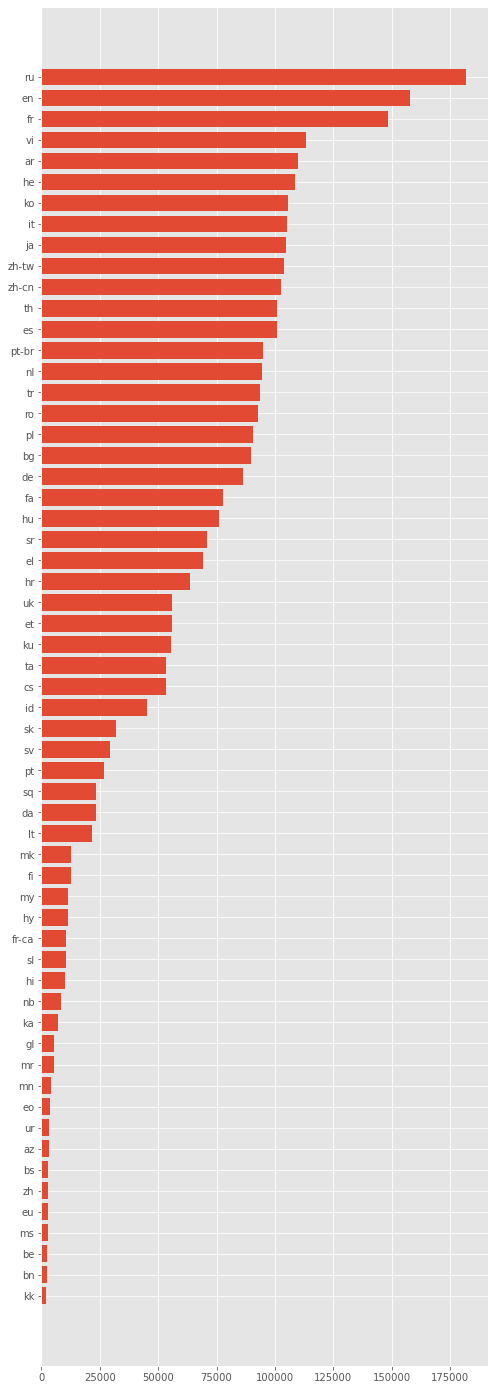

In [9]:
fig, ax = plt.subplots(figsize=(8,25))

ax.barh(lang_count['index'], lang_count['language'])
ax.invert_yaxis();

In [10]:
lang_count[lang_count['index'].apply(lambda x: x in {"en", "kk"})]

,index,language
1,en,157655
58,kk,2046


Датасет сильно не сбалансирован по классам, а требуется хорошее качество для всех языков, поэтому метрика в данном соревновании — взвешенная доля правильных ответов:

$$ 
\text{WeightedAccuracy}\left(y, \hat{y}, w\right) = \frac{\displaystyle{\sum_{i=1}^{n}} w_i \cdot \left(y_i == \hat{y}_i\right)}{\displaystyle\sum_{i=1}^{n} w_i } 
$$

Веса выбирались обратно пропорционально количеству примеров соответствующего языка:
$$
w\left(\text{"en"}\right) \sim \frac{1}{157655}
$$
$$ \dots $$
$$
w\left(\text{"kk"}\right) \sim \frac{1}{2046}
$$

Поэтому для валидации можно использовать [sklearn.metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)

# cleaning

In [11]:
def remove_f(text):
  no_f=[words for words in text if words not in ['&quot;',':', '♫', 'wk', 'tedx', 'foxp', 
                                                 'marshmallowchallenge.com', 'disney.com', 'mp3', 'will.i.am',
                                                 'heidegger', 'mutopo', 'openrov.com', 'fallor', 'kipp',
                                                 'insideoutproject.net', 'refaat', 'gangstabucks.com', 'www.randi.org',
                                                 'grl', 'ioo.exe', 's7', 'ifidie.net', 'skylife',
                                                 'arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 
                                                 'french', 'german', 'greek','hungarian', 'indonesian', 'italian', 
                                                 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 
                                                 'slovene', 'spanish', 'swedish', 'tajik', 'turkish',
                                                 '!','#','$','%','&','(',')','*','+','-','.','/',':',
                                                 ';','<','=','>','?','@','[',']','_','{','|','}','~']]
  words_wo_f=''.join(no_f)
  return words_wo_f
ttrain_df['sentence_f']=ttrain_df['sentence'].apply(lambda x: remove_f(x))
#ttrain_df.head()

In [12]:
def remove_punctuation(text):
  no_punct=[words for words in text if words not in '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~']
  words_wo_punct=''.join(no_punct)
  return words_wo_punct
ttrain_df['sentence_wo_punct']=ttrain_df['sentence'].apply(lambda x: remove_punctuation(x))

In [13]:
def tokenize(text):
    split=re.split("\W+",text) 
    return split
ttrain_df['sentence_split']=ttrain_df['sentence_f'].apply(lambda x: tokenize(x))
#ttrain_df.head()

In [14]:
lang=['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek','hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']
stopword_set = set()
for i in lang:
    stopword_set = stopword_set.union(set(nltk.corpus.stopwords.words(i)))

In [15]:
def remove_stopwords(text):
    text=[word for word in text if word not in stopword_set]
    return text
ttrain_df['stopwords'] = ttrain_df['sentence_split'].apply(lambda x: remove_stopwords(x))

In [16]:
def remove_punct(text):
  no_punct=[words for words in text if words not in ',']
  words_wo_punct=' '.join(no_punct)
  return words_wo_punct
ttrain_df['sentence1']=ttrain_df['stopwords'].apply(lambda x: remove_punct(x))

In [17]:
ttrain_df.head()

,sentence,language,sentence_f,sentence_wo_punct,sentence_split,stopwords,sentence1
0,"Pensez à la communication , le discours , les ...",fr,"Pensez à la communication , le discours , les ...",Pensez à la communication le discours les ge...,"[Pensez, à, la, communication, le, discours, l...","[Pensez, communication, discours, gestes, écri...",Pensez communication discours gestes écrire la...
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs,"Můžete si ji pronajmout , vzít na splátky , ko...",Můžete si ji pronajmout vzít na splátky koup...,"[Můžete, si, ji, pronajmout, vzít, na, splátky...","[Můžete, pronajmout, vzít, splátky, koupit, te...",Můžete pronajmout vzít splátky koupit technolo...
2,"Každý starosta pochopil , že když mají tyto fo...",cs,"Každý starosta pochopil , že když mají tyto fo...",Každý starosta pochopil že když mají tyto for...,"[Každý, starosta, pochopil, že, když, mají, ty...","[Každý, starosta, pochopil, když, mají, tyto, ...",Každý starosta pochopil když mají tyto formy m...
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv,"Det är ytterligare bevis , men ändå — Jag krit...",Det är ytterligare bevis men ändå — Jag kriti...,"[Det, är, ytterligare, bevis, men, ändå, Jag, ...","[Det, ytterligare, bevis, ändå, Jag, kritisera...",Det ytterligare bevis ändå Jag kritiserades fo...
4,كان الأمر لا يصدق .,ar,كان الأمر لا يصدق,كان الأمر لا يصدق,"[كان, الأمر, لا, يصدق, ]","[كان, الأمر, يصدق, ]",كان الأمر يصدق


In [18]:
#ttrain_df.drop(['sentence', 'sentence_wo_punct', 'sentence_split', 'stopwords'], axis='columns', inplace=True)
ttrain_df.drop(['sentence'], axis='columns', inplace=True)

In [19]:
ttrain_df = ttrain_df[['sentence_f', 'language']]
ttrain_df.head()

,sentence_f,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق,ar


# Train-test split

In [20]:
x = ttrain_df.values[:,  0]
label_encoder = LabelEncoder().fit(ttrain_df.values[:, 1])
y = label_encoder.transform(ttrain_df.values[:, 1])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

In [21]:
x

array(['Pensez à la communication , le discours , les gestes , écrire , le langage des signes , ils sont tous faits par lapos intermédiaire de contractions musculaires ',
       'Můžete si ji pronajmout , vzít na splátky , koupit technologii , která téměř stejná nebo stejná jako ta , kterou používají „ ti oprávnění quot quot  Žádná společnost neprospívá nejlépe , máli vše pod kontrolou jen elita ',
       'Každý starosta pochopil , že když mají tyto formy , mají i kulturu a turismus ',
       ...,
       'гэта што калі мы не яны як але ён каб дзякуй больш пра на вы',
       'що це тому ми чи дуже які щоб дякую якщо було вона від мене ось',
       'donde realizamos una reunión anual con varias personas , a la que llamamos Vida en el Espacio'],
      dtype=object)

# Model 1

In [22]:
from sklearn.naive_bayes import MultinomialNB

In [23]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', SGDClassifier(random_state=SEED, loss='modified_huber', class_weight='balanced'))
])

In [24]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model',
                 SGDClassifier(class_weight='balanced', loss='modified_huber',
                               random_state=42))])

In [25]:
predictions = pipe.predict(x_train)

In [26]:
balanced_accuracy_score(y_train, predictions)

0.915402234201123

In [27]:
test_predictions = pipe.predict(x_test)

In [28]:
balanced_accuracy_score(y_test, test_predictions)

0.8621125513155764

# Model 2

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer

In [30]:
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, ngram_range=(1, 1), min_df=3, max_df=0.8)),
    ('model', SGDClassifier(random_state=SEED, loss='modified_huber', class_weight= 'balanced'))
])

In [31]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(max_df=0.8, min_df=3)),
                ('model',
                 SGDClassifier(class_weight='balanced', loss='modified_huber',
                               random_state=42))])

In [32]:
predictions = pipeline.predict(x_train)

In [33]:
balanced_accuracy_score(y_train, predictions)

0.8951395573888754

In [34]:
test_predictions = pipeline.predict(x_test)

In [35]:
balanced_accuracy_score(y_test, test_predictions)

0.8700221818935825

# Submit 1

In [36]:
submit_predictions = pipe.predict(test_df.sentence.values)

In [37]:
test_df['language'] = label_encoder.classes_[submit_predictions]

test_df.head()

,index,sentence,language
0,0,תודה לכם .,he
1,1,"Precisamos de compaixão para começar , e auto-...",pt-br
2,2,這個增長相當大 ， 並且它將引發經濟的增長 。,zh-cn
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요 .,ko
4,4,これをロボットに組み込みました,zh-cn


In [38]:
(
    test_df[['index',  'language']]
    .to_csv('sample_submission.csv', index=False)
)

# Submit 2

In [39]:
submit_predictions = pipeline.predict(test_df.sentence.values)

In [40]:
test_df['language'] = label_encoder.classes_[submit_predictions]
#test_df.head()

In [41]:
(
    test_df[['index',  'language']]
    .to_csv('subm_modified_huber.csv', index=False)
)

# Homework

### Часть 1. (4 балла)
- исследовать данные
    - почистить обучающую выборку
        - есть ли ошибки в разметке?
    - посмотреть, какие символы / токены встречаются во всех языках
    - выделить коллокации для известных вам языков (хотя бы русский и английский)
- попробовать добавить в модель признаки на основе word2vec или topic modeling
- построить confusion_matrix и посмотреть, какие языки путает модель
- вывести top_k токенов с максимальной важностью для каждого класса
 
### Часть 2. (3 баллов)
- выбить хороший score на private leaderboard'е

In [42]:
y_test != test_predictions

array([False,  True, False, ..., False, False, False])

In [50]:
y_test.shape, test_predictions.shape

((600000,), (600000,))

In [48]:
new_df = test_df[:600000]
new_df['y_test'] = y_test
new_df['test_predictions'] = test_predictions

<ipython-input-48-2e62816faa62>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['y_test'] = y_test
<ipython-input-48-2e62816faa62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['test_predictions'] = test_predictions


In [49]:
new_df

,index,sentence,language,y_test,test_predictions
0,0,תודה לכם .,he,3,3
1,1,"Precisamos de compaixão para começar , e auto-...",pt-br,27,57
2,2,這個增長相當大 ， 並且它將引發經濟的增長 。,zh-cn,42,42
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요 .,ko,58,57
4,4,これをロボットに組み込みました,zh-cn,52,52
...,...,...,...,...,...
599995,599995,Och därför är jag ganska optimistisk om det .,sv,43,43
599996,599996,40億年間 突然変異を繰り返し 今この俺が出てきたから進化終了 終演 最後の最後 永久の最後...,zh-cn,50,50
599997,599997,E eu não sei qual a resposta para isto .,pt-br,10,10
599998,599998,Ben onun düşmanı oldum .,tr,26,26


In [51]:
train_df.dtypes.value_counts()

object    2
dtype: int64

In [52]:
train_df.isnull().sum()

sentence    0
language    0
dtype: int64

In [53]:
pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', TfidfVectorizer()),
  ('model',
   SGDClassifier(class_weight='balanced', loss='modified_huber', random_state=42))],
 'verbose': False,
 'vectorizer': TfidfVectorizer(),
 'model': SGDClassifier(class_weight='balanced', loss='modified_huber', random_state=42),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.float64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__norm': 'l2',
 'vectorizer__preprocessor': None,
 'vectorizer__smooth_idf': True,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__sublinear_tf': False,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__use_idf': True,
 'vectorizer__vocabul

In [54]:
stop_words = nltk.corpus.stopwords.words('russian')

In [55]:
 count_model = Pipeline([
    (
        'vectorizer',
        CountVectorizer(
            lowercase=True, ngram_range=(1, 1), token_pattern="[а-яё]+",
            stop_words=stop_words, min_df=3, max_df=0.8
        )
    ),
    ('clf', SGDClassifier(random_state=SEED, loss='log', class_weight='balanced'))
])

# Токенизация

In [56]:
import re
#import razdel
import nltk

In [57]:
a = list(train_df.sentence)

In [58]:
b =' '.join(a) 

In [59]:
nltk.tokenize.casual_tokenize(b)

MemoryError: 

In [ ]:
from collections import Counter 

In [ ]:
c = Counter(nltk.tokenize.casual_tokenize(b))

In [ ]:
с.hist(bins=200)

In [ ]:
nltk.corpus.stopwords.words('russian')